<a href="https://colab.research.google.com/github/Bastian1212/Hola_M/blob/main/Billionaires_poisson_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
# configuración de figuras
plt.rcParams["figure.figsize"] = (14, 6)  
import time

import scipy.optimize 
from scipy.special import factorial
import scipy.stats

# For bootstrap
from random import choices

# graphic loader
from tqdm import tqdm


In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/Bastian1212/work2/main/billonarios.csv", index_col="pais")
df.head()

,nbillonarios,logpibpc,logpob,gatt
pais,,,,
United States,469,10.786021,19.532846,60
Canada,25,10.743365,17.319439,0
"Bahamas, The",0,10.072139,12.760934,0
Aruba,0,10.223734,11.526276,0
Bermuda,0,11.446847,11.086334,0


# PARTE 1: Modelo (1.0pt)

### Implementando poisson probability mass function : 


$$
p(y_i | x_i ) = \frac{\lambda_i^{y_i}}{y_i!} \exp \left ({-\lambda_i} \right)
$$

In [ ]:
# Implementación de poisson probability mass function
def poisson(y, lambda_):
  return lambda_**y / factorial(y) * np.exp(-lambda_)


**1.1** Estudie y describa la distribución de Poisson en detalle. Muestre como varía la distribución en función de su parámetro $\lambda$, ¿Qué ocurre cuando $\lambda$ es pequeño? ¿Y cuando es grande?

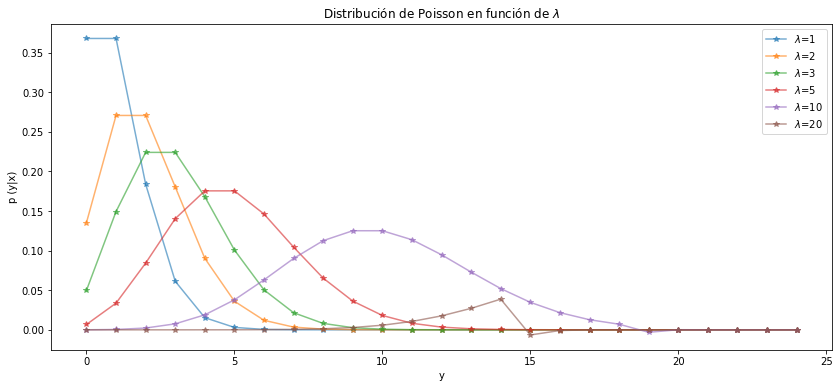

Figura 1: Distribución de Poisson en función de lambda.


In [ ]:
# Graficando diferentes distribuciones de poisson en función de su parámetro lambda

# lambdas a testear
lambdas = [ 1, 2, 3, 5, 10, 20]

# Y's (eje x) de 0 a 25 (discreto)
Y = np.arange(0, 25)

fig, ax = plt.subplots()

for lamb in lambdas:
  distribucion = []
  for y in Y:
    # para cada lambda y cada y calcular poisson value
    distribucion.append(poisson(y, lamb))
    
  # graficar subplot
  ax.plot(Y,
        distribucion,
        alpha=0.6,
        label='$\lambda$={}'.format(lamb),
        marker='*')
  
ax.set_xlabel('y')
ax.set_ylabel('p (y|x)')
ax.legend()
plt.title("Distribución de Poisson en función de $\lambda$")
plt.show()

print("Figura 1: Distribución de Poisson en función de lambda.")


Cuando $\lambda$ toma valores pequeños (ej. 1, 2, 3 y 5 en Figura 1), la distribución de Poisson tiene una forma asímetrica positiva (a la derecha) y a medida que $\lambda$ aumenta, la distribución tiende a normalizarse. 

Veamos como cambia la asimetría en función de $\lambda$:


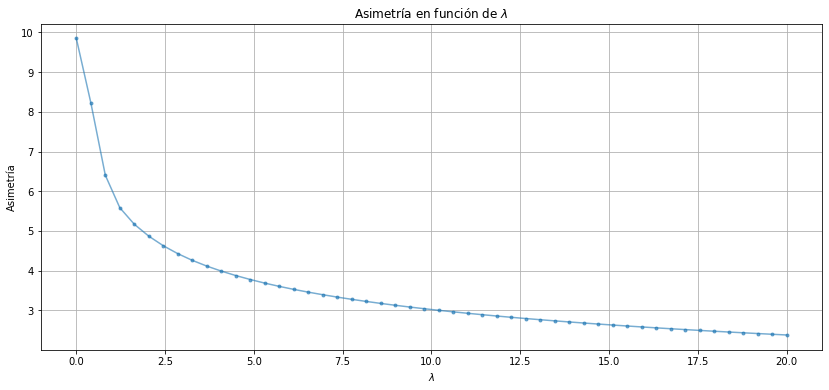

Figura 2: Variación de la asimetría de una distribución de Poisson en función de lambda.


In [ ]:
from scipy.stats import skew # Para estimar asimetría


# Graficando diferentes asimetrías en función de su parámetro lambda

# lambdas a testear
lambdas = np.linspace(0, 20)

# Y's (eje x) de 0 a 100 (discreto)
Y = np.arange(0, 100)

asimetrias = []
for lamb in lambdas:
  distribucion = []
  for y in Y:
    # para cada lambda y cada y calcular poisson value
    distribucion.append(poisson(y, lamb))
    # calcular asimetria
  asimetrias.append(skew(distribucion)) 
# graficar subplot
plt.plot(lambdas,
      asimetrias,
      alpha=0.6,
      label='$\lambda$={}'.format(lamb),
      marker='.')

plt.grid()
plt.xlabel('$\lambda$')
plt.ylabel('Asimetría')
plt.title("Asimetría en función de $\lambda$")
plt.show()

print("Figura 2: Variación de la asimetría de una distribución de Poisson en función de lambda.")


En la Figura 2 se observa como la asimetría de la distribución de Poisson disminuye a medida que $\lambda$ aumenta.

**NOTA**: Ahondar en el por qué esto ocurre (debido al [teorema del límite central](https://web.stanford.edu/class/archive/cs/cs109/cs109.1178/lectureHandouts/190-central-limit-theorem.pdf))

### ¿Los multi-millonarios en el mundo siguen una distribución de Poisson?

[Treisman (2016)](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.p20161068) estudia la cantidad de multi-millonarios (UDS billions) según las características del País. El autor utiliza una regresión de Poisson para demostrar que Rusia tiene más multi-millonarios que los esperados (según PIB, población, permanencia en GATT y WTO). Utilizar este tipo de estimadores (Poisson Regression) tiene más sentido que utilizar OLS (ordinary least squeares), puesto que la variable dependiente es un `count` (discreta, no negativa) y además se asume que los ricos por país están distribuidos de forma similar a una distribución de Poisson. 

A partir de la data entregada para esta tarea, podemos preguntarnos si realmente la asumpción es correcta, ¿Los multi-millonarios en el mundo siguen una distribución de Poisson?



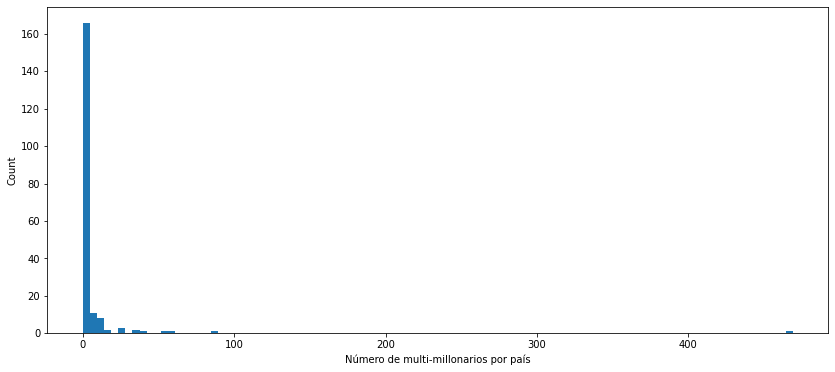

Figura 3: Distribución de multi-millonarios por país.


In [ ]:
# Veamos si los multi-millonarios por país siguen una distribución de Poisson
df["nbillonarios"].plot(kind='hist', bins=100)
plt.ylabel("Count")
plt.xlabel("Número de multi-millonarios por país")
plt.show()

print("Figura 3: Distribución de multi-millonarios por país.")

A primera vista la hipótesis de que los multi-millonarios por país siguen una distribución de Poisson parece acertada (exceptuando ciertos outliers). Se observa una distribución con una asimetría positiva, similar a las distribuciones de Poisson con un $\lambda$ bajo. 

¿Qué países son aquellos que se escapan de la distribución? 

In [ ]:
# Asimetría de los datos nbillonarios
print("Asimetría nbillonarios:", round(skew(df["nbillonarios"].values), 2))
print("_____________________________")
# Paises con mayores números de multi-millonarios
print("Top 5 países con más multi-millonarios")
df["nbillonarios"].sort_values(ascending=False).head(5)

Asimetría nbillonarios: 12.28
_____________________________
Top 5 países con más multi-millonarios


pais
United States         469
Russian Federation     87
Germany                59
India                  53
China                  42
Name: nbillonarios, dtype: int64

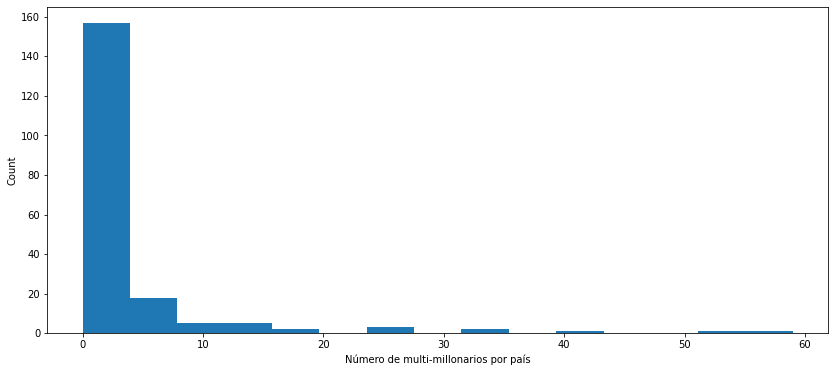

Figura 4: Distribución de multi-millonarios por país (Sin EEUU y Rusia).


In [ ]:
# El mismo gráfico que la figura 3 pero sin EEUU y Rusia
# Veamos si los multi-millonarios por país siguen una distribución de Poisson
df.loc[~df.index.isin(["United States", "Russian Federation"])]["nbillonarios"].plot(kind='hist', bins=15)
plt.ylabel("Count")
plt.xlabel("Número de multi-millonarios por país")
plt.show()

print("Figura 4: Distribución de multi-millonarios por país (Sin EEUU y Rusia).")


Sacando EEUU y Rusia, se observa de mejor manera la similitud de los datos a una distribución de Poisson con $\lambda$ bajo.

## PARTE 1.2

**1.2** Reemplace las expresiones y obtenga una expresión analítica para el logaritmo de la verosimilitud: $\log \mathcal{L}(\theta)$. Muestre la ecuación obtenida. HINT: Puede ignorar los términos que no dependan de $\theta$. Luego obtenga una expresión analítica para la primera derivada del logaritmo de la verosimilitud. Muestra la ecuación obtenida

# TO DO: Acá poner en LaTeX 

# PARTE 2: Implementación (1.5pt)
 
 **2.1** Implemente el logaritmo de la verosimilitud y su derivada usando `numpy`. Utilice operaciones vectoriales (prohibido usar `for` para iterar en los países).



Primero implementar una función para `intensidad` $\lambda$:

$$
\lambda_i = \exp \left (\theta_0 + \sum_{j=1}^M \theta_j x_{ij} \right)
$$

donde 

- $\theta$ es el vector de parámetros que deseamos ajustar 
- $y_i$ y $x_i$ son la cantidad de billonarios y el vector de atributos del país $i$, respectivamente




In [ ]:
# creando una copia del dataframe
df_copy = df.copy()

# Defininendo los vectores X e y
y = df_copy.pop("nbillonarios")
X = df_copy.values

# Estandarizar (restar la media y dividir por la desviación estandar)
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Agregar 1 en la primera columna para que theta[0]*x = theta[0]
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)

In [ ]:
# Implementación de intensidad
def intensidad(theta, X):
  return np.exp(np.matmul(X, theta)) # X0 = 1 por lo que se cumple la fórmula de intensidad

# Implementación del logaritmo de la verosimilitud negativo (para minimizar) 
def neg_log_verosimilitud(theta, X, y):
  lambda_ = intensidad(theta, X)
  # acá se puede obviar el termino np.log(factorial(y)) porque no depende de theta
  log_likelihood =np.sum(y * np.log(lambda_) - lambda_)

  return -log_likelihood

# Implementación de la derivada de log_verosimilitud
def derivada_log_verosimilitud(theta, X, y):
  lambda_ = intensidad(theta, X)
  return np.matmul(X.T, lambda_ - y)

## PARTE 2.2:
**2.2** Implemente una rutina que encuentre el vector de parámetros óptimo en base a `scipy.optimize.minimize` 

Métodos disponibles:


`Nelder-Mead `

`Powell`

`CG` 

`BFGS`

`Newton-CG`

`L-BFGS-B`

`TNC`

`COBYLA`

`SLSQP`

`trust-constr`

`dogleg`

`trust-ncg`

`trust-exact`

`trust-krylov`

In [ ]:
# Inicialización de theta
theta = np.array([0.1] * X.shape[-1])

res = scipy.optimize.minimize(fun = neg_log_verosimilitud, 
                              x0 = theta, 
                              method = 'Nelder-Mead', 
                              jac = derivada_log_verosimilitud, 
                              args=(X, y),
                              tol=1e-6)
print(res)

# Hay que corregir los problemas con logaritmos de 0 (no definido)

 final_simplex: (array([[1.24017337, 1.87699633, 0.12841121],
       [1.24017402, 1.87699555, 0.12841134],
       [1.24017413, 1.87699658, 0.12841074],
       [1.24017371, 1.87699566, 0.12841082]]), array([-3306.21338297, -3306.21338297, -3306.21338297, -3306.21338297]))
           fun: -3306.2133829661952
       message: 'Optimization terminated successfully.'
          nfev: 302
           nit: 165
        status: 0
       success: True
             x: array([1.24017337, 1.87699633, 0.12841121])


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  RuntimeWarning)


## PARTE 2.3:

**2.3** Implemente una rutina que calcule el pseudo coeficiente de correlación
$$
R^2 = \frac{\log \mathcal{L} (\hat \theta_0) - \log \mathcal{L} (\hat \theta) }{\log \mathcal{L} (\hat \theta_0)} \in [0, 1]
$$
donde $\log \mathcal{L} (\hat \theta)$ es el logaritmo de la verosimilitud de su mejor modelo y $\log \mathcal{L} (\hat \theta_0)$ es el logaritmo de la verosimilitud de un modelo que tiene sólo el parámetro $\theta_0$

In [ ]:
def R2(theta, X, y, theta_0):
  lambda_theta0 = np.exp(theta_0)
  log_ver_th_0 = np.sum(y * np.log(lambda_theta0) - lambda_theta0)
  log_ver_theta = -neg_log_verosimilitud(theta, X, y)
  return (log_ver_th_0 - log_ver_theta)/log_ver_th_0

In [ ]:
theta_0 = res.x[0] # usando sólo theta[0] 
r2 = R2(res.x, X, y, theta_0)
print("r2 = ", r2)


# CORREGIR R2 PORQUE DEBERÍA DAR ENTRE 0 Y 1, VER EL ERROR

r2 =  -3.6854113475423245


## **CORREGIR R2 PORQUE DEBERÍA DAR ENTRE 0 Y 1, VER EL ERROR**

## PARTE 2.4:
**2.4** Implemente una rutina de bootstrap resampling para encontrar la distribución y los intervalos de confianza empíricos para $\theta$ y el pseudo coeficiente de correlación

In [ ]:
# Bootstrap: Tirándonos para arriba con la correa de la bota
def bootstraping(X, y, n_iter=10000, metodo_estimador="BFGS"):
  # Lista vacía para agregar thetas empíricos en cada iteración 
  thetas = []
  # Lista vacía para agregar r2 empírico en cada iteración 
  r2s = []

  # Número de muestras
  n = X.shape[0]

  # Vamos a resamplear los índices del array, para sacar de X e y
  indices = [*range(n)]

  for _ in tqdm(range(n_iter)):
    resampled_indices = choices(indices, k=n)
    resampled_X = X[resampled_indices]
    resampled_y = y[resampled_indices]
  
    # Pasar la muestra resampleada al estimador (scipy.minimize)
    res = scipy.optimize.minimize(fun = neg_log_verosimilitud, 
                                x0 = theta, 
                                method = metodo_estimador, 
                                jac = derivada_log_verosimilitud, 
                                args=(resampled_X, resampled_y),
                                tol=1e-1)
    
    # agregar a lista thetas
    thetas.append(res.x)

    # agregar a r2s
    theta_0 = res.x[0]  
    r2 = R2(res.x, X, y, theta_0)
    r2s.append(r2)
  
  return np.array(thetas), np.array(r2s)

In [ ]:
thetas, r2s = bootstraping(X, y)

100%|██████████| 10000/10000 [02:11<00:00, 76.24it/s]


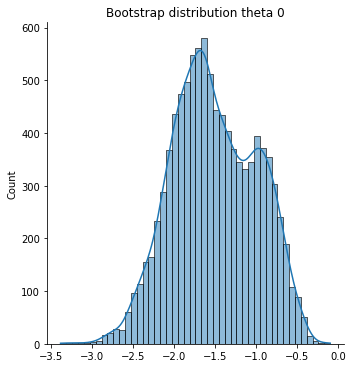

Intervalos de confianza theta 0
Intervalo Izquierdo: -1.522
Intervalo Derecho: -1.502
----------------------------------------


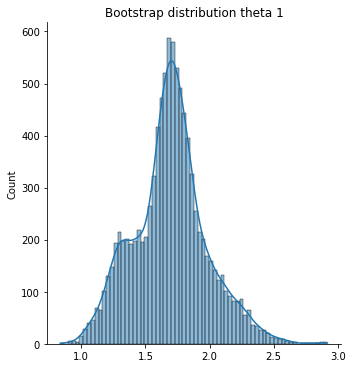

Intervalos de confianza theta 1
Intervalo Izquierdo: 1.689
Intervalo Derecho: 1.7
----------------------------------------


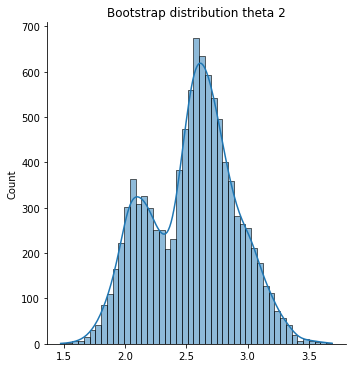

Intervalos de confianza theta 2
Intervalo Izquierdo: 2.54
Intervalo Derecho: 2.554
----------------------------------------


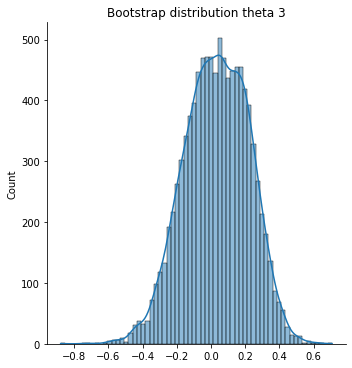

Intervalos de confianza theta 3
Intervalo Izquierdo: 0.029
Intervalo Derecho: 0.036
----------------------------------------


In [ ]:

# Graficando distribución boostrap de cada theta con sus respectivos intervalos de confianza
for i in range(thetas.shape[-1]): # para cada theta
  data = thetas[:, i] # seleccionando theta

  # calculando intervalos de confianza
  ic_izq, ic_der = scipy.stats.norm.interval(0.95, 
                                             loc=np.mean(data), 
                                             scale=scipy.stats.sem(data))

  # Ploteando
  ax = sns.displot(data, kde=True)
  plt.title(f"Bootstrap distribution theta {i}")
  plt.show()
  print(f"Intervalos de confianza theta {i}")
  print("Intervalo Izquierdo:", round(ic_izq,3))
  print("Intervalo Derecho:", round(ic_der,3))
  print("----------------------------------------")


A medida que las muestras aumentan, la distancia entre la media y los intervalos de confianza disminuyen

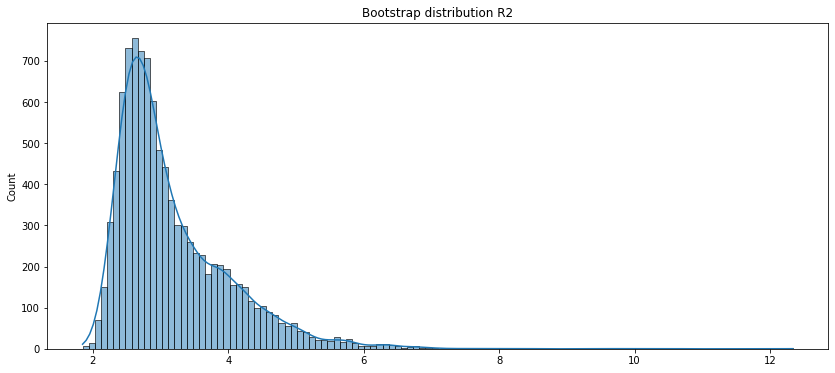

Intervalos de confianza R2
Intervalo Izquierdo: 3.157
Intervalo Derecho: 3.19


In [ ]:
# ARREGLAR R2 (DEBE SER ENTRE 0 y 1)
# Boostrap distribution de R2
sns.histplot(r2s, kde=True)
plt.title(f"Bootstrap distribution R2")
plt.show()

# calculando intervalos de confianza
ic_izq, ic_der = scipy.stats.norm.interval(0.95, 
                                            loc=np.mean(r2s), 
                                            scale=scipy.stats.sem(r2s))

print("Intervalos de confianza R2")
print("Intervalo Izquierdo:", round(ic_izq,3))
print("Intervalo Derecho:", round(ic_der,3))

# PARTE 3: Resultados (3pt)

**3.1.** Compare los métodos `CG`, `BFGS`, `Nelder-mead` y `Powell` en términos del vector de parámetros obtenido, la log verosimilitud alcanzada, el pseudo coeficiente de correlación alcanzado, el número de iteraciones necesarias para converger y el tiempo total para converger. Seleccione uno de los métodos para contestar los siguientes puntos

In [ ]:
metodos = ["CG", "BFGS", "Nelder-Mead", "Powell"]

# inicializando un diccionario donde guardaremos todos los resultados
resultados = dict()

for metodo in tqdm(metodos):
  # diccionario del método
  dict_metodo = dict()

  # Inicialización de theta
  theta = np.array([0.1] * X.shape[-1])

  # temporizar
  start = time.time()

  # Pasar la muestra resampleada al estimador (scipy.minimize)
  res = scipy.optimize.minimize(fun = neg_log_verosimilitud, 
                            x0 = theta, 
                            method = metodo, 
                            jac = derivada_log_verosimilitud, 
                            args=(X, y),
                            tol=1e-6)

  end = time.time()
  total_time = end - start
  # agregar a lista thetas
  dict_metodo["tiempo"] = total_time
  dict_metodo["thetas"] = res.x
  dict_metodo["log_verosimilitud"] = -neg_log_verosimilitud(res.x, X, y)
  dict_metodo["iteraciones"] = res.nit
  
  # calculando r2
  theta_0 = res.x[0]  
  r2 = R2(res.x, X, y, theta_0)
  dict_metodo["r2"] = r2

  # agregando el diccionario del metodo al diccionario de resultados
  resultados[metodo] = dict_metodo




  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  RuntimeWarning)
 75%|███████▌  | 3/4 [00:00<00:00,  9.74it/s]/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
100%|██████████| 4/4 [00:00<00:00,  6.94it/s]


In [ ]:
resultados

{'BFGS': {'iteraciones': 15,
  'log_verosimilitud': 3459.0919420729174,
  'r2': 2.861980553168679,
  'thetas': array([-1.62704503,  1.73933685,  2.59760107,  0.13179676]),
  'tiempo': 0.016349077224731445},
 'CG': {'iteraciones': 47,
  'log_verosimilitud': 3459.0919420729165,
  'r2': 2.8619805218120855,
  'thetas': array([-1.62704506,  1.73933685,  2.59760108,  0.13179677]),
  'tiempo': 0.07111406326293945},
 'Nelder-Mead': {'iteraciones': 235,
  'log_verosimilitud': 3459.091942072886,
  'r2': 2.8619801830685017,
  'thetas': array([-1.62704537,  1.73933706,  2.59760135,  0.13179649]),
  'tiempo': 0.21634173393249512},
 'Powell': {'iteraciones': 9,
  'log_verosimilitud': 3459.0916762813436,
  'r2': 2.864554339254204,
  'thetas': array([-1.62466879,  1.7388497 ,  2.596631  ,  0.13152722]),
  'tiempo': 0.2632284164428711}}

In [ ]:
pd.DataFrame(resultados).T

,tiempo,thetas,log_verosimilitud,iteraciones,r2
CG,0.0711141,"[-1.6270450589854406, 1.7393368531036575, 2.59...",3459.09,47,2.86198
BFGS,0.0163491,"[-1.6270450299984256, 1.7393368465210892, 2.59...",3459.09,15,2.86198
Nelder-Mead,0.216342,"[-1.6270453721306444, 1.739337060069844, 2.597...",3459.09,235,2.86198
Powell,0.263228,"[-1.6246687926065504, 1.7388497045711797, 2.59...",3459.09,9,2.86455


**3.2.** Prediga la cantidad de billonarios de cada país usando su modelo. Muestre la cantidad de billonarios predicha y real para cada continente. ¿Qué puede comentar al respecto?

In [ ]:
# Usando Powell (probar con otros si se desea)
thetas = resultados["Powell"]["thetas"]
# predicciones
y_hat = intensidad(thetas, X)

# agregando y y y_hat a un dataframe
pred_df = pd.DataFrame({"real":y, "prediccion":y_hat})

# agregando el error
pred_df["error"] = np.absolute(pred_df["real"] - pred_df["prediccion"])
pred_df.sort_values("error", ascending=False).head(40)

,real,prediccion,error
pais,,,
United States,469,357.276854,111.723146
Japan,24,95.535727,71.535727
Russian Federation,87,27.432048,59.567952
China,42,83.355713,41.355713
France,14,54.138434,40.138434
Italy,13,42.723019,29.723019
India,53,27.102621,25.897379
"Hong Kong SAR, China",26,2.147184,23.852816
Turkey,35,11.933297,23.066703


En general el valor predicho tiene relación con el real, pero hay un gran margen de error, sobre todo en los países con más millonarios. 

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("MAE:", mean_absolute_error(y, y_hat))

MAE: 3.256102849633795


Aunque el error absoluto promedio resulta ser bajo, esto se debe a los países que tienen muy pocos millonarios. Si calculamos el error medio al cuadrado, este mostraría el efecto de los países con hartos millonarios y harto error en la predicción.

In [ ]:
print("MSE:", mean_squared_error(y, y_hat))

MSE: 144.4654868343485


**3.3.** Muestre las distribuciones empíricas de los parámetros y del pseudo coeficiente de correlación. ¿Cuáles parámetros tienen $\theta$ significativamente distinto de cero? ¿Cuál es el intervalo de confianza al 95% del $R^2$? En base a esto ¿Qué puede decir sobre su modelo?

# TO DO: VER BIEN LA IMPLEMENTACION DE R2 PARA RESPONDER ESTO

**3.4.** Gráfique el error entre la cantidad de billonarios predicha y la cantidad de billonarios real. El gráfico debe mostrar los paises ordenados de mayor a menor **error absoluto**.  Analice ¿Cuáles son los 5 países con mayor error en la predicción? ¿Cuáles países tienen un exceso de billonarios? ¿Cúales paises tienen menos billonarios de lo esperado? ¿Qué puede decir sobre Rusia?


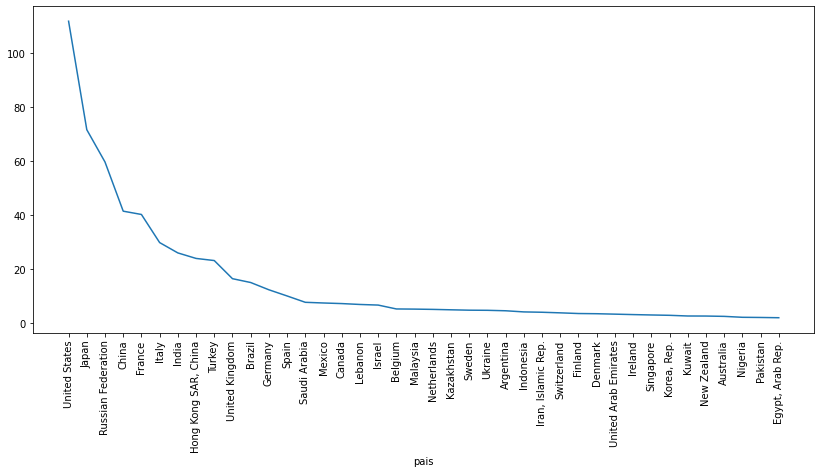

In [ ]:
NUM_PAISES = 40

error_pais = pred_df.sort_values("error", ascending=False)["error"].head(NUM_PAISES)

ax = error_pais.plot()
ax.set_xticks(range(len(error_pais)));
ax.set_xticklabels([item for item in error_pais.index.tolist()], rotation=90)
plt.show()

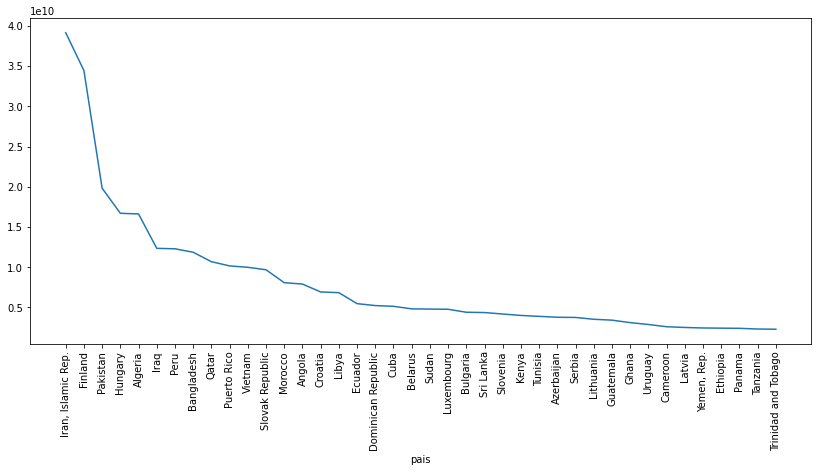

In [ ]:
# Error como porcentaje en los paises con más error
pred_dff = pred_df
pred_df["error_porcentaje"] = pred_df["error"] * 100 / (pred_df["real"] + 1e-8)

error_porc_pais = pred_df.sort_values("error_porcentaje", ascending=False)["error_porcentaje"].head(NUM_PAISES)

ax = error_porc_pais.plot()
ax.set_xticks(range(len(error_porc_pais)));
ax.set_xticklabels([item for item in error_porc_pais.index.tolist()], rotation=90)
plt.show()

In [ ]:
pred_df

,real,prediccion,error,error_porcentaje
pais,,,,
United States,469,357.276854,111.723146,2.382157e+01
Canada,25,17.871789,7.128211,2.851285e+01
"Bahamas, The",0,0.041513,0.041513,4.151283e+08
Aruba,0,0.011526,0.011526,1.152561e+08
Bermuda,0,0.025913,0.025913,2.591286e+08
...,...,...,...,...
"Micronesia, Fed. Sts.",0,0.000888,0.000888,8.875074e+06
Samoa,0,0.002596,0.002596,2.595946e+07
"Hong Kong SAR, China",26,2.147184,23.852816,9.174160e+01
